<a href="https://colab.research.google.com/github/gonzalorodriguezrovira/TFG_SkinAnalizer/blob/main/Codigo/TFG_Diagnostico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modulos**

In [ ]:
!pip install -q efficientnet

In [ ]:
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from efficientnet.tfkeras import EfficientNetB7
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model
from google.colab import auth
from PIL import Image, ImageDraw




import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import PIL
import math
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
import random


AUTO = tf.data.AUTOTUNE

# **Funciones para carga y trato de datase**

In [ ]:
# Prepara la imagen redimensionandola y normalizando los pixeles
def prepare_image(image_data):
  image = tf.image.decode_jpeg(image_data, channels=3)
  image = tf.reshape(image, [*IMAGE_SIZE, 3])
  image = tf.cast(image, tf.float32) / 255.0
  return image

# Función para extraer la informacion de los TFRecord
def read_labeled_tfrecord_with_file_name(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "patient_id": tf.io.FixedLenFeature([], tf.int64),
        "sex": tf.io.FixedLenFeature([], tf.int64),
        "age_approx": tf.io.FixedLenFeature([], tf.int64),
        "anatom_site_general_challenge": tf.io.FixedLenFeature([], tf.int64),
        "diagnosis": tf.io.FixedLenFeature([], tf.int64),
        "target": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = prepare_image(example['image'])
    image_name = example['image_name']
    diagnosis = tf.cast(example['diagnosis'], tf.int32)
    return image, image_name, diagnosis


# Filtro para eliminar las imagenes que contienen dowsampled
def filter_images(image, image_name, diagnosis):
  return not tf.strings.regex_full_match(image_name,"^((.*_downsampled))")

# Función para suprimir el nombre del fichero de los registros
def remove_file_name(image, file, target):
  return image, target

# Función para cargar en un dataset los TFRecords
# Devuelve un dataset con el formato (image, image_name, diagnosis)
def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.map(read_labeled_tfrecord_with_file_name,
                          num_parallel_calls=AUTO).filter(filter_images)
    return dataset

def load_GCS():
    auth.authenticate_user()
    drive.mount('/content/gdrive', force_remount=True)

    dataset_files = {}

    dataset_files["256x256"] = tf.io.gfile.glob("gs://tfgtfrecords/256x256/train*.tfrec")
    dataset_files["384x384"] = tf.io.gfile.glob("gs://tfgtfrecords/384x384/train*.tfrec")
    dataset_files["512x512"] = tf.io.gfile.glob("gs://tfgtfrecords/512x512/train*.tfrec")
    dataset_files["768x768"] = tf.io.gfile.glob("gs://tfgtfrecords/768x768/train*.tfrec")

    dataset = {}
    global IMAGE_SIZE
    for resolution, files in dataset_files.items():
        IMAGE_SIZE = RESOLUTIONS[resolution]
        dataset[resolution] = load_dataset(files)

    df_ISIC=pd.read_csv('/content/gdrive/MyDrive/df_ISIC_MOD.csv')

    return df_ISIC,dataset


def transform_dataset(dataset_dict):
    def transform_diagnosis(img, file, diagnosis):
        # Condicional para asignar 1 si el valor está en {9, 11, 16}, y 0 en caso contrario
        nueva_diagnosis = tf.where(tf.reduce_any(tf.math.equal(diagnosis, [1, 9, 11, 16])),
                                   tf.constant(1, dtype=tf.int32),
                                   tf.constant(0, dtype=tf.int32))

        # Eliminar la fila si diagnosis es 17, es decir unknown
        return tf.cond(tf.math.equal(diagnosis, 17),
                       lambda: (img, file, diagnosis),
                       lambda: (img, file, nueva_diagnosis))

    # Aplicar la transformación a cada elemento de cada conjunto de datos en el diccionario
    dataset_transformado = {}
    for resolution, ds in dataset_dict.items():
        dataset_transformado[resolution] = ds.map(transform_diagnosis).filter(lambda img, file, diagnosis: tf.math.not_equal(diagnosis, 17))

    return dataset_transformado

def split_data(ds):
  # Primero se muestra la distribución de maligno y benigno del dataset original
  y_targets = np.array([diagnosis.numpy() for img, file, diagnosis in iter(ds[MODEL_RESOLUTION])])
  X_indices = np.arange(len(y_targets))

  print("Porcentaje dataset original")
  print_target_counts(y_targets, "Total")

  X_exp_indices, X_test_indices, y_exp_targets, y_test_targets = train_test_split(
      X_indices, y_targets, test_size=0.15, stratify=y_targets, random_state=53)

  ds_exp = {}
  ds_test = {}
  for resolution, full_dataset in dataset.items():
    ds_exp[resolution] =  get_selected_dataset(full_dataset, X_exp_indices)
    ds_test[resolution] =  get_selected_dataset(full_dataset, X_test_indices)

  y_targets = np.array([diagnosis.numpy() for img, file, diagnosis in iter(ds_exp[MODEL_RESOLUTION])])
  X_indices = np.arange(len(y_targets))

  X_train_indices, X_val_indices, y_train_targets, y_val_targets = train_test_split(
      X_indices, y_targets, test_size=0.15, stratify=y_targets, random_state=53)

  ds_train = {}
  ds_val = {}
  for resolution, experiment_dataset in ds_exp.items():
    ds_train[resolution] =  get_selected_dataset(experiment_dataset, X_train_indices)
    ds_val[resolution] =  get_selected_dataset(experiment_dataset, X_val_indices)

  NUM_TRAINING_IMAGES = len(y_train_targets)
  NUM_VALIDATION_IMAGES = len(y_val_targets)

  # Cálculo del bías inicial
  _, (y_target_neg_count, y_target_pos_count) = np.unique(y_targets, return_counts=True)
  y_target_pos_ratio = y_target_pos_count / y_target_neg_count
  dence_initial_bias = math.log(y_target_pos_ratio)
  dense_bias_initializer = Constant(dence_initial_bias)

  print("Porcentaje dataset entrenamiento")
  print_target_counts(y_train_targets, "Entrenamiento")

  print("Porcentaje dataset validación")
  print_target_counts(y_val_targets, "Validación")

  print("Porcentaje dataset prueba final")
  print_target_counts(y_test_targets, "Prueba:")

  return ds_train,ds_val,ds_test,dense_bias_initializer,NUM_TRAINING_IMAGES,NUM_VALIDATION_IMAGES



# Función para extraer un dataset de otro dataset dados los índices
# (se utiliza para particionar un dataset)
def get_selected_dataset(ds, X_indices_np):
    # Crea un tensor del tipo tf.int64 como el de Dataset.enumerate().
    X_indices_ts = tf.constant(X_indices_np, dtype=tf.int64)

    # Función que devuelve True si el índice esta incluido en X_indices_ts
    def is_index_in(index, rest):
        return tf.math.reduce_any(index == X_indices_ts)

    def drop_index(index, rest):
        return rest

    # Dataset.enumerate() is similter to Python's enumerate().
    # Se filtran los indices que se han pasado como parámetro y se devuelve el
    # dataset con dichos índices
    selected_ds = ds \
        .enumerate() \
        .filter(is_index_in) \
        .map(drop_index)
    return selected_ds

# Función que devuelve el dataset de entrenamiento
def get_training_dataset(ds, do_augment=False):
    dataset = ds
    dataset = ds.map(remove_file_name)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    if do_augment:  dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.prefetch(AUTO)
    return dataset

# Función que devuelve el dataset de validación
def get_validation_dataset(ds):
    dataset = ds
    dataset = ds.map(remove_file_name)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

# Función que devuelve el dataset de prueba
def get_test_dataset(ds):
    dataset = ds
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset


# **Funciones trato de imagenes**

In [ ]:
def data_augment(image, target):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image  = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    return image, target

# **Funciones para visualización de imagenes**

In [ ]:
def show_images(dataset,n):
  examples=dataset[MODEL_RESOLUTION].take(n)
  for img, file, diagnosis in iter(examples):
    file_name = file.numpy().decode('ascii')
    diagnosis = "Maligno" if diagnosis==9 or diagnosis==11 or diagnosis==16 else "Benigno"
    image = PIL.Image.fromarray((img.numpy() * 255).astype(np.uint8))
    print("File: {} Size: {} Benign_malignant: {}".format(file_name, image.size,diagnosis))
    plt.imshow(image)
    plt.show()
    print("\n")

def show_images_diagnosis(diag,dataset):
  diag_int=transform_diagnosis(diag)
  if diag_int==-1:
    print('Diagnostico no enconcontrado')
    return
  dataset=dataset[MODEL_RESOLUTION]
  img, file, diagnosis=get_sample_by_diagnosis(dataset,diag_int)
  file_name = file.numpy().decode('ascii')
  diagnosis = "Maligno" if diagnosis==9 or diagnosis==11 or diagnosis==16 else "Benigno"
  image = PIL.Image.fromarray((img.numpy() * 255).astype(np.uint8))
  print("File: {} Size: {} diagnosis: {} {}".format(file_name, image.size,diagnosis,diag))
  plt.axis('off')
  plt.imshow(image)
  plt.show()
  print("\n")

  # Función para mostrar un mosaico con imágenes
def show_mosaic_images(thumb_size, cols, rows, ds):
    ds = ds[MODEL_RESOLUTION]
    ds=ds.take(100).shuffle(64)
    mosaic = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), thumb_size*rows + (rows-1)))
    for idx, data in enumerate(iter(ds)):
        img, target = data[0], data[1]
        ix  = idx % cols
        iy  = idx // cols
        img = PIL.Image.fromarray((img.numpy() * 255).astype(np.uint8))
        img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        mosaic.paste(img, (ix*thumb_size + ix,
                           iy*thumb_size + iy))
        if idx > cols*rows: break
    display(mosaic)

# **Modelo**

In [ ]:
# Función que devuelve una fila para añadir a un dataframe con las métricas
def create_metric_row(resolution, version, lr, bias, dropout, model_history,ep):
  # Crea una nueva fila con las estadísticas del último epoch del entrenamento
  val_auc_roc = round(model_history['val_auc_roc'] [-1],3)
  val_auc_pr = round(model_history['val_auc_pr'] [-1],3)
  val_precision = round(model_history['val_precision'] [-1],3)
  val_recall = round(model_history['val_recall'] [-1], 3)
  val_F1 = round(2*val_precision*val_recall / (val_precision+val_recall),3)

  new_row = {'resolucion': resolution,
             'version_modelo': version,
             'epocas':ep,
             'lr': lr,
             'bias': bias,
             'dropout': dropout,
             'val_auc_roc': val_auc_roc,
             'val_auc_pr': val_auc_pr,
             'val_precision': val_precision,
             'val_recall': val_recall,
             'val_F1': val_F1
             }
  return new_row

# Funcióm para crear un modelo EfficientNet
def create_model(lr=0.00005, init_bias=False,
                 dropout=0.2, dense_bias_initializer=0, effnet_version=4):
  BATCH_SIZE = 16 * strategy.num_replicas_in_sync


  eff_function = {
      0: efn.EfficientNetB0,
      1: efn.EfficientNetB1,
      2: efn.EfficientNetB2,
      3: efn.EfficientNetB3,
      4: efn.EfficientNetB4,
      5: efn.EfficientNetB5,
      6: efn.EfficientNetB6,
      7: efn.EfficientNetB7
  }

  K.clear_session()

  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

  with strategy.scope():

      # Capas de EfficientNet
      eff_function = eff_function[effnet_version]
      effnet_layer = eff_function(
                include_top=False, weights="noisy-student",
                input_shape=(*IMAGE_SIZE, 3), pooling='avg')



      # Capa Dense (totalmente conectada)
      if init_bias:
        dense_layer = Dense(1, bias_initializer=dense_bias_initializer,
                      activation='sigmoid',name='classify')
      else:
        dense_layer = Dense(1, activation='sigmoid',name='classify')

      # Se crea el modelo
      if (dropout > 0):
        model = Sequential([
                effnet_layer,
                Dropout(dropout, name="dropout"),
                dense_layer])
      else:
        model = Sequential([
                effnet_layer,
                dense_layer])

      # Métricas que se van a medir
      metrics = [ AUC(name='auc_roc', curve='ROC'),
                 AUC(name='auc_pr', curve='PR'),
                 Precision(name='precision'), Recall(name='recall') ]

  # Compila el modelo
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
  model.summary()

  return model

# Funcion para sacar el mejor modelo considerando el campo mas importante val_precision teniendo este un valor de 1.3 respecto a los demas
def select_model(df,n):
    df_selected = df[['val_auc_roc', 'val_auc_pr', 'val_precision', 'val_recall']]
    df_sum = []

    for index, row in df_selected.iterrows():
        df_sum.append(row.sum() + row['val_recall'] * 0.3)

    # Obtener los índices de los n mayores valores
    top_n_indices = np.argsort(df_sum)[-n:][::-1]

    # Obtener las filas correspondientes a los índices seleccionados del DataFrame original
    top_n_rows = df.loc[top_n_indices]

    return top_n_rows

# Función para mostrar una curva de rendimiento del entrenamiento
def display_training_curve(training, validation, title, subplot, ylim):
  # Se definen los subplots en la primera llamada
  if subplot%10==1:
      plt.subplots(figsize=(8,8), facecolor='#dfdfdf')
      plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title(title)
  ax.set_ylabel(title)
  ax.set_ylim(*ylim)
  ax.set_xlabel('Épocas')
  ax.legend(['Entrenamiento', 'Validación'])

# Función para mostrar las curvas de rendimiento del entrenamiento de modelo
def display_curves(history):
  display_training_curve(
      history.history['auc_roc'], history.history['val_auc_roc'],
      'AUC ROC', 221, (0.5, 1.0))
  display_training_curve(
      history.history['auc_pr'], history.history['val_auc_pr'],
      'AUC PR', 222, (0.5, 1.0))
  display_training_curve(
      history.history['precision'], history.history['val_precision'],
      'Precision', 223, (0.0, 1.0))
  display_training_curve(
      history.history['recall'], history.history['val_recall'],
      'Recall', 224, (0.0, 1.0))

# Función de checkpoint para guardar el mejor modelo según una métrica
# durante el entrenamiento
def make_model_check_point(best_model_file_path, metric='val_auc_pr'):
    return ModelCheckpoint(
        best_model_file_path, monitor=metric, mode='max',
        verbose=1, save_best_only=True, save_weights_only=False, period=1)

# **Funciones auxiliares**

In [ ]:
def get_sample_by_diagnosis(dataset, target_diagnosis):
    dataset_diag = dataset.filter(lambda img, file, diagnosis: diagnosis == target_diagnosis)
    dataset_diag=dataset_diag.take(100).shuffle(64)
    img, file, diagnosis = next(iter(dataset_diag.take(1)))
    return img, file, diagnosis

def transform_diagnosis(diag):
  if diag=="MEL":
    return 9
  if diag=="NV":
    return 10
  if diag=="BCC":
    return 11
  if diag=="AK":
    return 12
  if diag=="BKL":
    return 13
  if diag=="DF":
    return 14
  if diag=="VASC":
    return 15
  if diag=="SCC":
    return 16
  return -1

# Función para imprimir el total de casos de cada categoría y el el porcentaje de
# la categoría positiva respecto al total
def print_target_counts(y, label):
    _, y_counts = np.unique(y, return_counts=True)
    y_total = len(y)
    y_0_count = y_counts[0]
    y_1_count = y_counts[1]
    y_1_percent = y_1_count / y_total * 100.0
    print("{0:10s}: Total={1:5d}, 0={2:5d}, 1={3:3d}, porcentaje maligno={4:.2f}%\n".format(
        label, y_total, y_0_count, y_1_count, y_1_percent))

# Funcion almacenar imagenes
def save_images():
  neg=0
  pos=0
  for img, file, diagnosis in iter(get_test_dataset(ds_test[MODEL_RESOLUTION]).unbatch()):

    if diagnosis.numpy() == 1 and neg<25:
      neg = neg + 1
      file_name = file.numpy().decode('ascii')+'MAL' + '.jpg'
      image= PIL.Image.fromarray((img.numpy() * 255).astype(np.uint8))
      image.save("/content/gdrive/MyDrive/ImagenesTest/" + file_name)

    else:
      if pos<25:
        pos = pos + 1
        file_name = file.numpy().decode('ascii')+'BENIG' + '.jpg'
        image= PIL.Image.fromarray((img.numpy() * 255).astype(np.uint8))
        image.save("/content/gdrive/MyDrive/ImagenesTest/" + file_name)


    if neg==25 and pos==25: break

# **Configuración hardware**

In [ ]:
# Detecta hardware, devuelve la estrategia de distribución apropiada el HW.
try:
    # TPU detectada
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('TPU disponible ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()
    print("GPUs disponibles: ", len(tf.config.list_physical_devices('GPU')))

print("Réplicas:", strategy.num_replicas_in_sync)

# Configura el tamaño del batch
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
print("Tamaño de batch:", BATCH_SIZE)

TPU disponible  
Réplicas: 8
Tamaño de batch: 128


# **Resolución**

In [ ]:
RESOLUTIONS = {
  "256x256": [256, 256],
  "384x384": [384, 384],
  "512x512": [512, 512],
  "768x768": [768, 768]
}

# Resolución para el proceso
MODEL_RESOLUTION = "256x256"

df_ISIC,dataset=load_GCS()

Mounted at /content/gdrive


In [ ]:
show_images(dataset,2)

PermissionDeniedError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} Error executing an HTTP request: HTTP response code 403 with body '{
  "error": {
    "code": 403,
    "message": "The billing account for the owning project is disabled in state closed",
    "errors": [
      {
        "message": "The billing account for the owning project is disabled in state closed",
        "domain": "global",
        "reason": "accountDisabled",
        "locationType": "header",
        "location": "Authorization"
      }
    ]
  }
}
'
	 when reading metadata of gs://tfgtfrecords/256x256/train00-858.tfrec [Op:IteratorGetNext] name: 

In [ ]:
show_images_diagnosis('BCC',dataset)

PermissionDeniedError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} Error executing an HTTP request: HTTP response code 403 with body '<?xml version='1.0' encoding='UTF-8'?><Error><Code>UserProjectAccountProblem</Code><Message>The project to be billed is associated with a closed billing account.</Message><Details>The billing account for the owning project is disabled in state closed</Details></Error>'
	 when reading gs://tfgtfrecords/256x256/train00-858.tfrec [Op:IteratorGetNext] name: 

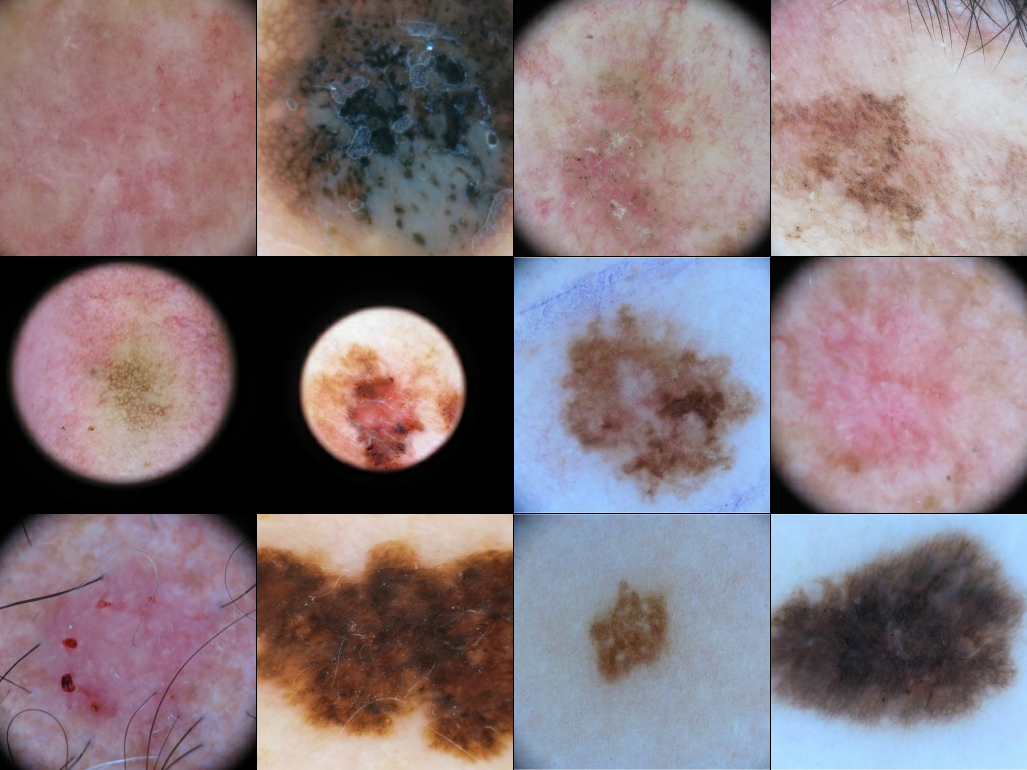

In [ ]:
show_mosaic_images(256, 4, 3, dataset)


In [ ]:
dataset=transform_dataset(dataset)

In [ ]:
ds_train,ds_val,ds_test,dense_bias_initializer,NUM_TRAINING_IMAGES,NUM_VALIDATION_IMAGES=split_data(dataset)

Exception ignored in: <function Executor.__del__ at 0x7860c6080040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Porcentaje dataset original
Total     : Total=23218, 0=15128, 1=8090, porcentaje maligno=34.84%



Exception ignored in: <function Executor.__del__ at 0x7860c6080040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Porcentaje dataset entrenamiento
Entrenamiento: Total=16774, 0=10930, 1=5844, porcentaje maligno=34.84%

Porcentaje dataset validación
Validación: Total= 2961, 0= 1929, 1=1032, porcentaje maligno=34.85%

Porcentaje dataset prueba final
Prueba:   : Total= 3483, 0= 2269, 1=1214, porcentaje maligno=34.86%



In [ ]:
#Se muestra el formato de cada uno de los dataset obtenidos
print(ds_train)
print(ds_val)
print(ds_test)

{'256x256': <_MapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>, '384x384': <_MapDataset element_spec=(TensorSpec(shape=(384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>, '512x512': <_MapDataset element_spec=(TensorSpec(shape=(512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>, '768x768': <_MapDataset element_spec=(TensorSpec(shape=(768, 768, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>}
{'256x256': <_MapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=No

In [ ]:
# Cálculo de los pasos por época
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE  * 1

# **Experimentos**

In [ ]:
# Se crea un dataframe para almacenar los resultados de los experimentos
df_metrics = pd.DataFrame(columns=['resolucion',
                                   'version_modelo',
                                   'epocas',
                                   'lr',
                                   'bias',
                                   'dropout',
                                   'val_auc_roc',
                                   'val_auc_pr',
                                   'val_precision',
                                   'val_recall',
                                   'val_F1'])

### Experimento learning rate
- EfficientNet-B0
- Resolución 256x256
- Sin sesgo inicial
- Sin dropout
- Learning rate: [0.00500, 0.00100, 0.00050, 0.00010, 0.00005]
- Epocas 15


In [ ]:
# Semilla aleatoria para reproductibilidad
tf.keras.utils.set_random_seed(32)

# Parametros
version=0
MODEL_RESOLUTION = "256x256"
IMAGE_SIZE = RESOLUTIONS[MODEL_RESOLUTION]
bias=0
dropout=0
learning_rate =  [0.00500, 0.00100, 0.00050, 0.00010, 0.00005]
epocas=15

for lr in learning_rate:
  print("**************************")
  print("Experimento lr=", lr)
  print("**************************")
  model = create_model(lr=lr,
                     init_bias=False,
                     dropout=dropout,
                     effnet_version=version)

  # Se entrena el modelo
  history = model.fit(
    get_training_dataset(ds_train[MODEL_RESOLUTION]),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=15, validation_data=get_validation_dataset(ds_val[MODEL_RESOLUTION]),
    verbose=1)


  # Se almacenan la media de los resultados
  new_row = create_metric_row("256x256", 'B'+str(version), lr=lr, bias=bias, dropout=dropout,
                              model_history=history.history, ep=epocas)

  df_metrics = df_metrics.append(new_row, ignore_index=True)

In [ ]:
# Métricas de los experimentos
df_metrics

,resolucion,version_modelo,epocas,lr,bias,dropout,val_auc_roc,val_auc_pr,val_precision,val_recall
0,256x256,B0,15,0.00500,0,0.0,0.837,0.720,0.653,0.733
1,256x256,B0,15,0.00100,0,0.0,0.887,0.850,0.872,0.659
2,256x256,B0,15,0.00050,0,0.0,0.916,0.863,0.812,0.806
3,256x256,B0,15,0.00010,0,0.0,0.918,0.878,0.839,0.781
4,256x256,B0,15,0.00005,0,0.0,0.920,0.873,0.808,0.777


In [ ]:
select_model(df_metrics,3)

,resolucion,version_modelo,epocas,lr,bias,dropout,val_auc_roc,val_auc_pr,val_precision,val_recall
3,256x256,B0,15,0.00010,0,0.0,0.918,0.878,0.839,0.781
2,256x256,B0,15,0.00050,0,0.0,0.916,0.863,0.812,0.806
4,256x256,B0,15,0.00005,0,0.0,0.920,0.873,0.808,0.777


### Conclusiones

Como lo que mas se valora en este estudio es reducir el numero de falsos negativos se seleccionan los tres mejores respecto al val_precision lr: 0.001, .0005, 0.00005. Por lo tanto, para el proximo experimento se seleccionan esos valores y un valor menor al ultimo para comprobar si al seguir dismuyendolo mejoraran los resultados como parece al final.

### Experimento sesgo inicial
- EfficientNetB0
- Resolución 256x256
- Sesgo inicial
- Sin dropout
- Learning rate: [0.0005, 0.0001, 0.00005, 0.000001]
- Epocas 15


In [ ]:
# Semilla aleatoria para reproductibilidad
tf.keras.utils.set_random_seed(32)

# Parametros
version=0
MODEL_RESOLUTION = "256x256"
IMAGE_SIZE = RESOLUTIONS[MODEL_RESOLUTION]
bias=1
dropout=0
IMAGE_SIZE = RESOLUTIONS[MODEL_RESOLUTION]
learning_rate = [0.0005, 0.0001, 0.00005, 0.000001]
epocas=15


# Crea y entrena los modelos
for lr in learning_rate:
  print("**************************")
  print("Experimento sesgo + lr=", lr)
  print("**************************")
  model = create_model(lr=lr,
                     init_bias=True,
                     dense_bias_initializer=dense_bias_initializer,
                     dropout=dropout,
                     effnet_version=version)

  # Se entrena el modelo
  history = model.fit(
    get_training_dataset(ds_train[MODEL_RESOLUTION]),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=epocas, validation_data=get_validation_dataset(ds_val[MODEL_RESOLUTION]),
    verbose=1)

  # Se almacenan los resultados
  new_row = create_metric_row(MODEL_RESOLUTION, 'B'+str(version), lr=lr, bias=bias, dropout=dropout,
                              model_history=history.history,ep=epocas)

  df_metrics = df_metrics.append(new_row, ignore_index=True)


In [ ]:
df_metrics

,resolucion,version_modelo,epocas,lr,bias,dropout,val_auc_roc,val_auc_pr,val_precision,val_recall,val_F1
0,256x256,B0,15,0.000500,1,0.0,0.908,0.859,0.857,0.726,0.786
1,256x256,B0,15,0.000100,1,0.0,0.921,0.873,0.834,0.783,0.808
2,256x256,B0,15,0.000050,1,0.0,0.923,0.878,0.834,0.769,0.800
3,256x256,B0,15,0.000001,1,0.0,0.819,0.676,0.723,0.410,0.523


In [ ]:
select_model(df_metrics,3)

### Conclusiones

Como podemos ver el sesgo no mejora los resultados anteriores, ademas vemos que el mejor resultado sigue siendo con el lr: 0.0001. Por lo tanto, para el proximo experimento se tomara ese lr y no se usará sesgo

### Experimento dropout
- EfficientNet-B0
- Resolución 256x256
- Sin sesgo inicial
- Dropout: [0.2, 0.3, 0.4, 0.5]
- Learning rate: 0.0001
- Epocas 15


In [ ]:
# Semilla aleatoria para reproductibilidad
tf.keras.utils.set_random_seed(32)

version=0
MODEL_RESOLUTION = "256x256"
IMAGE_SIZE = RESOLUTIONS[MODEL_RESOLUTION]
bias=0
dropout = [0.2, 0.3, 0.4, 0.5]
lr = 0.0001
epocas=15

for d_out in dropout:
  print("**************************")
  print("Experimento con dropout=", d_out)
  print("**************************")
  model = create_model(lr=lr,
                     init_bias=False,
                     dense_bias_initializer=dense_bias_initializer,
                     dropout=d_out,
                     effnet_version=version)
  # Se entrena el modelo
  history = model.fit(
    get_training_dataset(ds_train[MODEL_RESOLUTION]),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=epocas, validation_data=get_validation_dataset(ds_val[MODEL_RESOLUTION]),
    verbose=1)

  # Se almacenan los resultados
  new_row = create_metric_row(MODEL_RESOLUTION,'B'+str(version), lr=lr, bias=bias, dropout=d_out, model_history=history.history,ep=epocas)

  df_metrics = df_metrics.append(new_row, ignore_index=True)

In [ ]:
df_metrics

,resolucion,version_modelo,epocas,lr,bias,dropout,val_auc_roc,val_auc_pr,val_precision,val_recall,val_F1
0,256x256,B0,15,0.005000,0,0.0,0.837,0.720,0.653,0.733,0.691
1,256x256,B0,15,0.001000,0,0.0,0.887,0.850,0.872,0.659,0.751
2,256x256,B0,15,0.000500,0,0.0,0.916,0.863,0.812,0.806,0.809
3,256x256,B0,15,0.000100,0,0.0,0.918,0.878,0.839,0.781,0.809
4,256x256,B0,15,0.000050,0,0.0,0.920,0.873,0.808,0.777,0.792
5,256x256,B0,15,0.000500,1,0.0,0.908,0.859,0.857,0.726,0.786
6,256x256,B0,15,0.000100,1,0.0,0.921,0.873,0.834,0.783,0.808
7,256x256,B0,15,0.000050,1,0.0,0.923,0.878,0.834,0.769,0.800
8,256x256,B0,15,0.000001,1,0.0,0.819,0.676,0.723,0.410,0.523
9,256x256,B0,15,0.000100,0,0.2,0.922,0.876,0.829,0.786,0.807


In [ ]:
select_model(df_metrics,1)

,resolucion,version_modelo,epocas,lr,bias,dropout,val_auc_roc,val_auc_pr,val_precision,val_recall,val_F1
1,256x256,B0,15,0.0001,1,0.0,0.921,0.873,0.834,0.783,0.808


### Conclusiones

Como podemos observar conseguimos una mejora en todos los campos exceptuando el val_precision, el cual sigue teniendo un buen resultado al incorporar un dropout de 0.4, por lo que para los siguientes experimentos se mantendrá el dropout de 0.4.  

### Experimentos versiones
- EfficientNet-B1/2/3/4/5/6/7
- Resolución 256x256
- Sin sesgo inicial
- Dropout: 0.4
- Learning rate: 0.0001
- Epocas 15


In [ ]:
# Semilla aleatoria para reproductibilidad
tf.keras.utils.set_random_seed(32)

MODEL_RESOLUTION = "256x256"
IMAGE_SIZE = RESOLUTIONS[MODEL_RESOLUTION]
bias=0
dropout = 0.4
lr = 0.0001
epocas=15

for version in range(1,7):
  print("**************************")
  print("Experimento version=", version)
  print("**************************")
  model = create_model(lr=lr,
                     init_bias=False,
                     dense_bias_initializer=dense_bias_initializer,
                     dropout=dropout,
                     effnet_version=version)
  # Se entrena el modelo
  history = model.fit(
    get_training_dataset(ds_train[MODEL_RESOLUTION]),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=epocas, validation_data=get_validation_dataset(ds_val[MODEL_RESOLUTION]),
    verbose=1)

  # Se almacenan los resultados
  new_row = create_metric_row(MODEL_RESOLUTION,"B" + str(version), lr=lr, bias=bias, dropout=dropout, model_history=history.history,ep=epocas)

  df_metrics = df_metrics.append(new_row, ignore_index=True)

In [ ]:
df_metrics

In [ ]:
select_model(df_metrics,1)

### Conclusiones

Como se puede observar los mejores resultados se obtienen con la versión 5 de effnet, mejoreando los resultados generales sobretodo en la precisión, por lo que para los siguientes experimentos se usará esta version 5 de effnet.

### Experimento epocas
- EfficientNet-B5
- Resolución 256x256
- Sin sesgo inicial
- Dropout: 0.4
- Learning rate: 0.0001
- Epocas [10,13,16,19,22,25,50]


In [ ]:
# Semilla aleatoria para reproductibilidad
tf.keras.utils.set_random_seed(32)

version=5
MODEL_RESOLUTION = "256x256"
IMAGE_SIZE = RESOLUTIONS[MODEL_RESOLUTION]
bias=0
dropout = 0.4
lr = 0.0001
epocas=[10,13,16,19,22,25]

for ep in epocas:
  print("**************************")
  print("Experimento epocas=", ep)
  print("**************************")

  model = create_model(lr=lr,
                     init_bias=False,
                     dense_bias_initializer=dense_bias_initializer,
                     dropout=dropout,
                     effnet_version=version)


  # Se entrena el modelo
  history = model.fit(
    get_training_dataset(ds_train[MODEL_RESOLUTION]),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=ep, validation_data=get_validation_dataset(ds_val[MODEL_RESOLUTION]),
    verbose=1)

  # Se almacenan los resultados
  new_row = create_metric_row(MODEL_RESOLUTION,"B"+str(version), lr=lr, bias=bias, dropout=dropout, model_history=history.history,ep=ep)

  df_metrics = df_metrics.append(new_row, ignore_index=True)

In [ ]:
df_metrics

In [ ]:
select_model(df_metrics,1)

### Conclusiones

Como podemos observar al tener 16 epocas mejora en todos los campos, especialmente en val_precision por lo que se usará para los demas experimentos 16 epocas.

### Experimentos resoluciones
- EfficientNet-B5
- Resolución 256x256/384x384/512x512/768x768
- Sin sesgo inicial
- Dropout: 0.4
- Learning rate: 0.0001
- Epocas 16


In [ ]:
# Semilla aleatoria para reproductibilidad
tf.keras.utils.set_random_seed(32)

version=5
MODEL_RESOLUTIONS = ["384x384","512x512"]# impossible "768x768" datos demasiado grandes
bias=0
dropout = 0.4
lr = 0.0001
epocas=16



for MODEL_RESOLUTION in MODEL_RESOLUTIONS:
  IMAGE_SIZE = RESOLUTIONS[MODEL_RESOLUTION]
  print("**************************")
  print("Experimento con dropout=", MODEL_RESOLUTION)
  print("**************************")

  model = create_model(lr=lr,
                     init_bias=False,
                     dense_bias_initializer=dense_bias_initializer,
                     dropout=dropout,
                     effnet_version=version)

  # Se entrena el modelo
  history = model.fit(
    get_training_dataset(ds_train[MODEL_RESOLUTION]),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=epocas, validation_data=get_validation_dataset(ds_val[MODEL_RESOLUTION]),
    verbose=1)

  # Se almacenan los resultados
  new_row = create_metric_row(MODEL_RESOLUTION,"B"+str(version), lr=lr, bias=bias, dropout=dropout, model_history=history.history,ep=epocas)

  df_metrics = df_metrics.append(new_row, ignore_index=True)

ValueError: All arrays must be of the same length

In [ ]:
df_metrics

In [ ]:
select_model(df_metrics,1)

### Conclusiones

Como se puede observar al usar imagenes de 512x512 nos da una mejora general, por lo que se tomara esta medida para experimentos posteriores.

### Mejor modelo

- EfficientNet-B5
- Resolución 512x512
- Sin sesgo inicial
- Dropout: 0.4
- Learning rate: 0.0001
- Epocas 16


In [ ]:
# Crea un checkpoint para utilizar por el modelo
best_model = make_model_check_point("modelo.h5")

# Semilla aleatoria para reproductibilidad
tf.keras.utils.set_random_seed(32)

version=5
MODEL_RESOLUTION = "512x512"
IMAGE_SIZE = RESOLUTIONS[MODEL_RESOLUTION]
bias=0
dropout = 0.4
lr = 0.0001
epocas=16

print("**************************")
print("Modelo optimo")
print("**************************")
model = create_model(lr=lr,
                     init_bias=False,
                     dense_bias_initializer=dense_bias_initializer,
                     dropout=dropout,
                     effnet_version=version)
# Se entrena el modelo
history = model.fit(
    get_training_dataset(ds_train[MODEL_RESOLUTION]),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=epocas, validation_data=get_validation_dataset(ds_val[MODEL_RESOLUTION]),
    callbacks=[best_model],
verbose=1)

# Se almacenan los resultados
new_row = create_metric_row(MODEL_RESOLUTION,"B"+str(version), lr=lr, bias=bias, dropout=dropout, model_history=history.history,ep=epocas)

df_metrics = df_metrics.append(new_row, ignore_index=True)

**************************
Modelo optimo
**************************
115255328/115255328 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b5 (Functional  (None, 2048)             28513520  
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 classify (Dense)            (None, 1)                 2049      
                                                                 
Total params: 28,515,569
Trainable params: 28,342,833
Non-trainable params: 172,736
_________________________________________________________________
Epoch 1/16
131/131 [==============================] - ETA: 0s - loss: 0.4699 - auc_roc: 0.8357 - auc_

<ipython-input-14-98d475fd4242>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(new_row, ignore_index=True)


In [ ]:
df_metrics.tail(1)

,resolucion,version_modelo,epocas,lr,bias,dropout,val_auc_roc,val_auc_pr,val_precision,val_recall,val_F1
0,512x512,B5,16,0.0001,0,0.4,0.941,0.916,0.872,0.835,0.853


### Conclusiones

<ipython-input-18-59f5627dbc65>:106: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


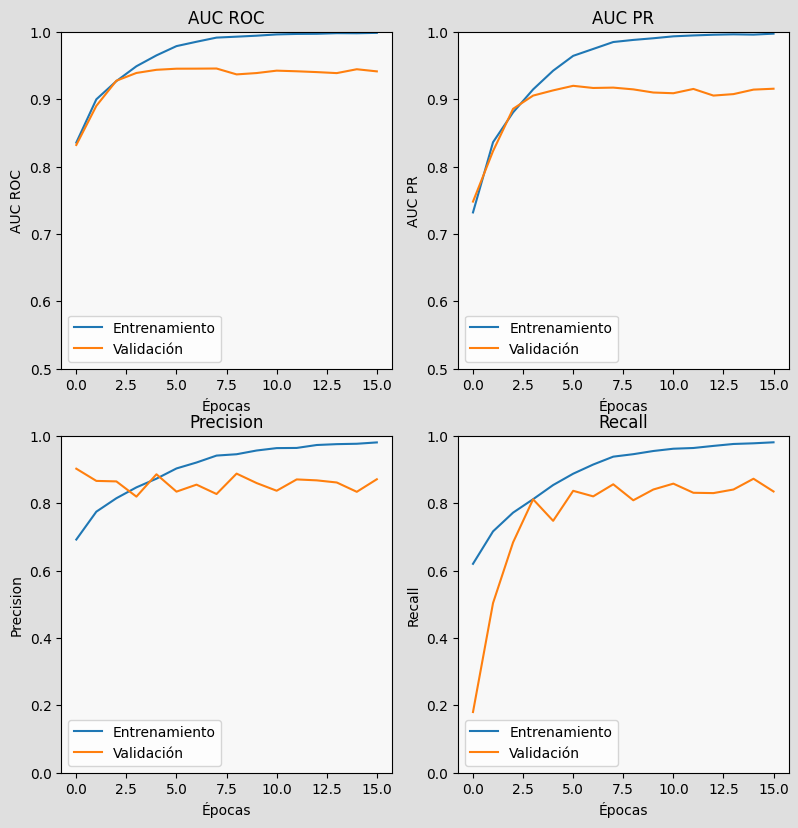

In [ ]:
# Se muestran las curvas de rendimiento del modelo durante el entrenamiento
display_curves(history)

In [ ]:
# Almacena métricas
df_metrics.to_csv('/content/gdrive/MyDrive/df_metrics.csv', index=False)
# Almacena el mejor modelo
model.save('/content/gdrive/MyDrive/Modelo/model.hdf5')

In [ ]:
!pip install -q tensorflowjs
!pip install tensorrt
!tensorflowjs_converter --input_format keras '/content/gdrive/MyDrive/Modelo/model.h5' '/content/gdrive/MyDrive/Modelo'

2024-04-05 20:49:33.194021: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 958, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 962, in main
    convert(argv[0].split(' '))
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 948, in convert
    _dispatch_converter(input_format, output_format, args, quantization_dtype_map,
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 618, in _dispatch_converter
    dispatch_keras_h5_to_tfjs_layers_model_conversion(
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 83, in di

In [ ]:
# Se carga el mejor modelo
model_load = load_model('/content/gdrive/MyDrive/Modelo/model.hdf5')

In [ ]:
# Se realizan las predicciones del modelo sobre el conjunto de prueba
# Etiquetas con el diagnóstico real
MODEL_RESOLUTION = "512x512"
IMAGE_SIZE = RESOLUTIONS[MODEL_RESOLUTION]

y_true = np.array([
  diagnosis.numpy() for img, file_name,
  diagnosis in iter(get_test_dataset(ds_test[MODEL_RESOLUTION]).unbatch())])

# Etiquetas con la predicción del modelo
y_pred = model_load.predict(get_test_dataset(ds_test[MODEL_RESOLUTION])).flatten()

print("Número de etiquetas con diagnósticos reales: ", y_true.shape)
print("Número de etiquetas predichas:", y_pred.shape)

Exception ignored in: <function Executor.__del__ at 0x79507ef08dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x794d5843a830>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.e

Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x794d5843a830>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
28/28 [==============================] - 204s 7s/step
Número de etiquetas con diagnósticos reales:  (3483,)
Número de etiquetas predichas: (3483,)


In [ ]:
# Prepara un fichero CSV con el nombre del fichero de imagen,
# diagnóstico real y predicción (probabilidades)
header = ['image_name', 'diagnosis', 'prediction']
with open('/content/gdrive/MyDrive/df_prediction.csv', 'w', encoding='UTF8') as f:
  writer = csv.writer(f)
  # Cabecera
  writer.writerow(header)
  idx = 0
  for img, file, diagnosis in iter(get_test_dataset(ds_test[MODEL_RESOLUTION]).unbatch()):
    writer.writerow([file.numpy().decode('ascii'),
          diagnosis.numpy(),
          y_pred[idx]])
    idx = idx + 1

Exception ignored in: <function Executor.__del__ at 0x79507ef08dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


ISIC_0000199.png Real: Benigno  - Predicción:[9.45558e-11]


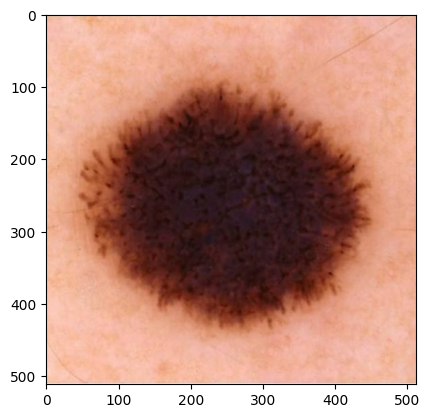

ISIC_0053543.png  Real: Maligno  - Predicción:[0.41658175]


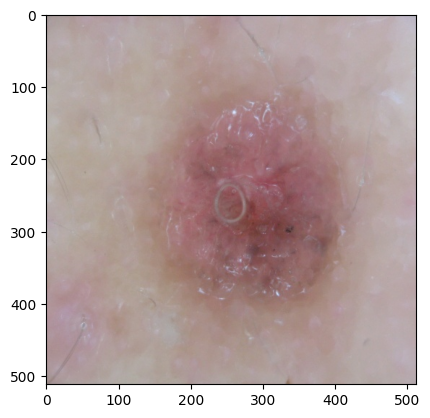

ISIC_0053533.png  Real: Maligno  - Predicción:[0.8807821]


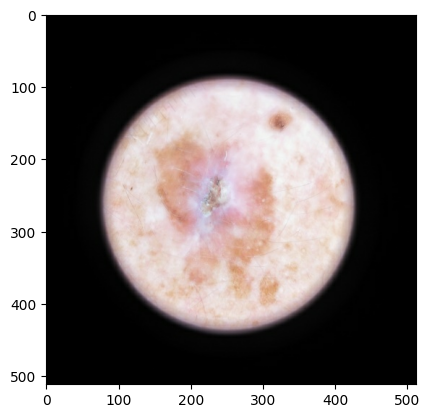

ISIC_0053550.png  Real: Maligno  - Predicción:[0.8970212]


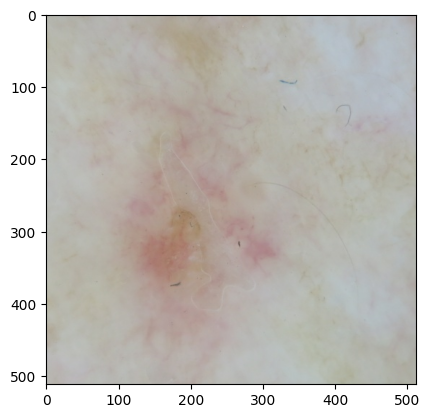

ISIC_0053528.png Real: Benigno  - Predicción:[0.00010528]


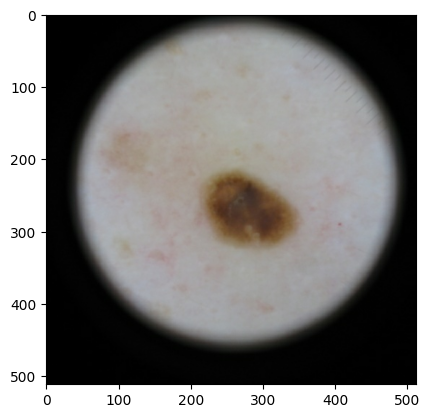

ISIC_0000074.png  Real: Maligno  - Predicción:[0.22921723]


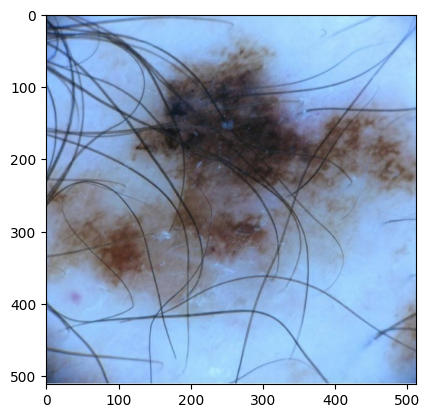

ISIC_0000073.png Real: Benigno  - Predicción:[6.3070634e-06]


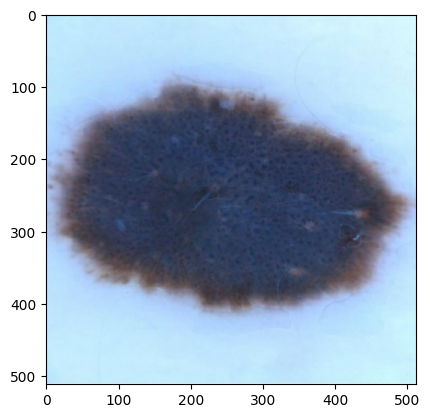

ISIC_0053568.png  Real: Maligno  - Predicción:[0.99998194]


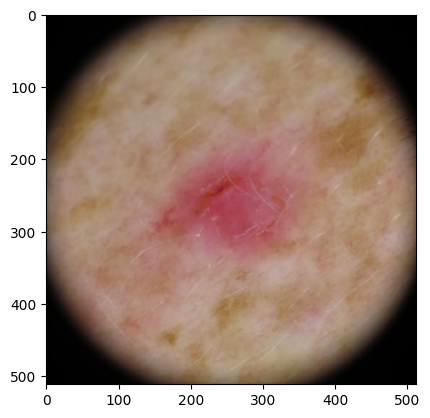

ISIC_0000246.png Real: Benigno  - Predicción:[6.38853e-07]


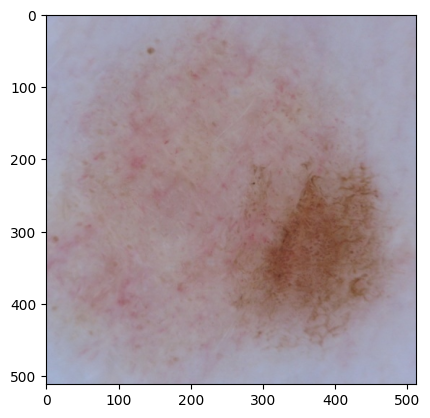

ISIC_0053691.png  Real: Maligno  - Predicción:[0.9999965]


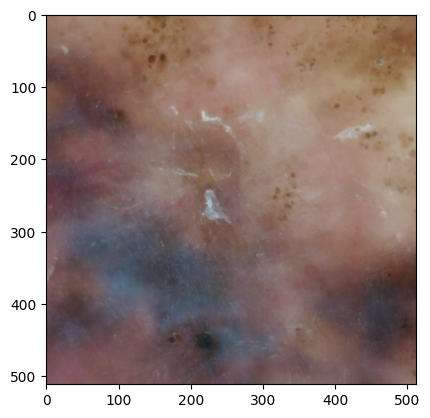

Exception ignored in: <function Executor.__del__ at 0x79507ef08dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


In [ ]:
# Muestra 10 ejemplos de diagnósticos
ds_test_ex=ds_test[MODEL_RESOLUTION].take(10)

for img, file, diagnosis in iter(get_test_dataset(ds_test_ex).unbatch()):
  file_name = file.numpy().decode('ascii') + '.png'
  diagnosis_diag = " Real: Maligno" if diagnosis.numpy() else "Real: Benigno"
  image = PIL.Image.fromarray((img.numpy() * 255).astype(np.uint8))
  tensor = tf.keras.utils.img_to_array(img)
  tensor = tf.expand_dims(tensor,0)
  prediction = " - Predicción:" +  str(model_load.predict(tensor, verbose=0).flatten())
  print(file_name, diagnosis_diag, prediction)
  plt.imshow(image)
  plt.show()

In [ ]:
# Funcion para almacenar imagenes para hacer pruebas
MODEL_RESOLUTION = "512x512"
save_images()

Este notebook fue inspirado inspirado por:

TFRecord Experiments - Upsample and Coarse Dropout https://www.kaggle.com/code/cdeotte/tfrecord-experiments-upsample-and-coarse-dropout/notebook
Splitting TensorFlow Dataset for Validation https://www.kaggle.com/code/tt195361/splitting-tensorflow-dataset-for-validation/notebook
Rotation Augmentation GPU/TPU - [0.96+] https://www.kaggle.com/code/cdeotte/rotation-augmentation-gpu-tpu-0-96/notebook
Classification on imbalanced data https://www.tensorflow.org/tutorials/structured_data/imbalanced_data